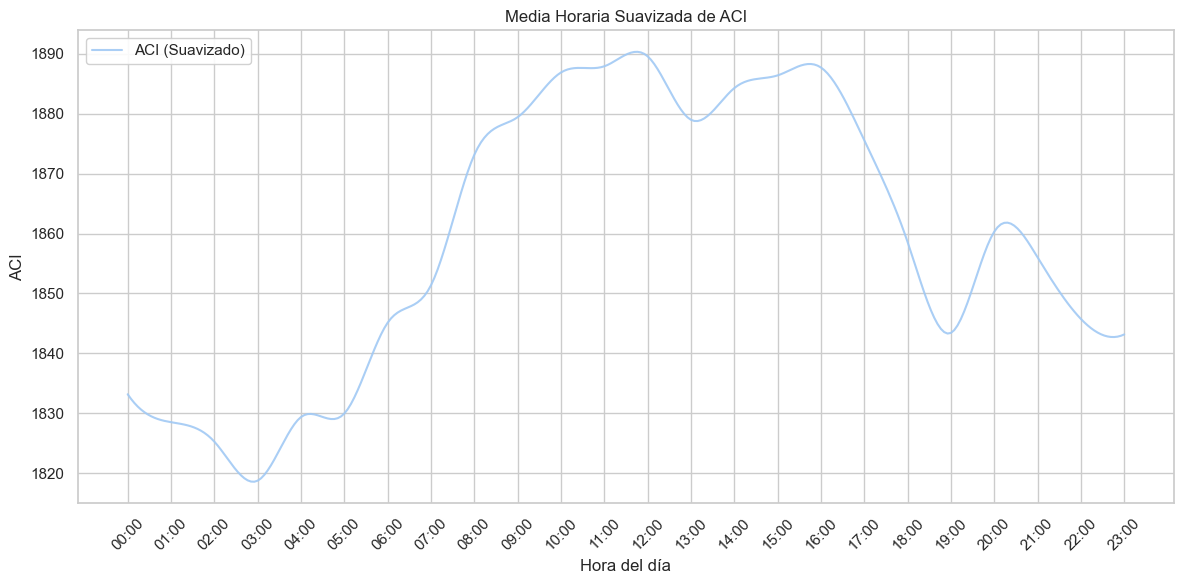

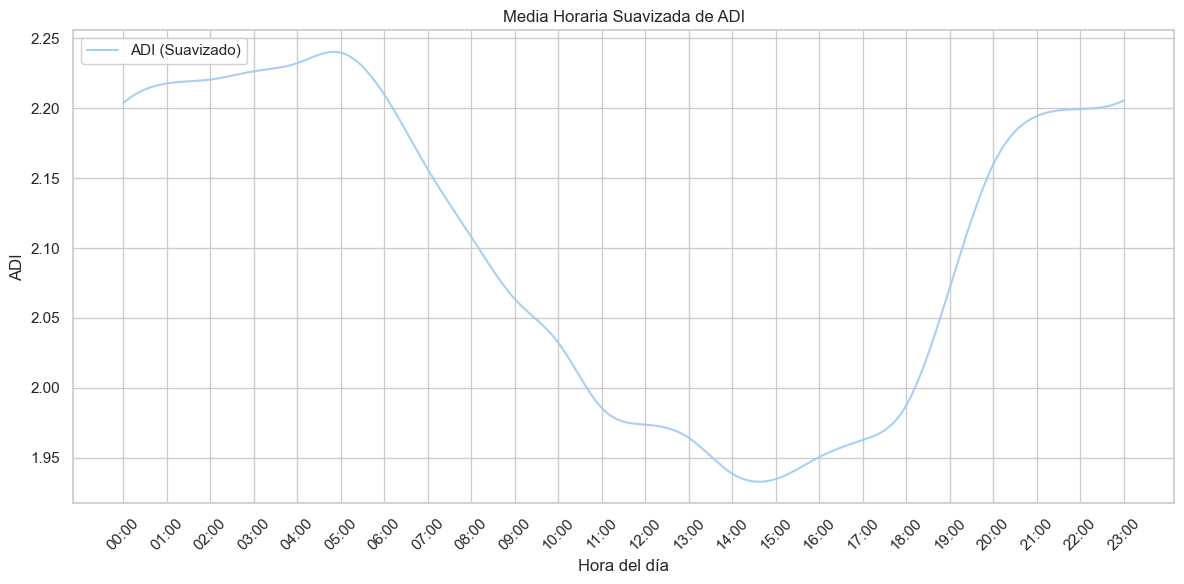

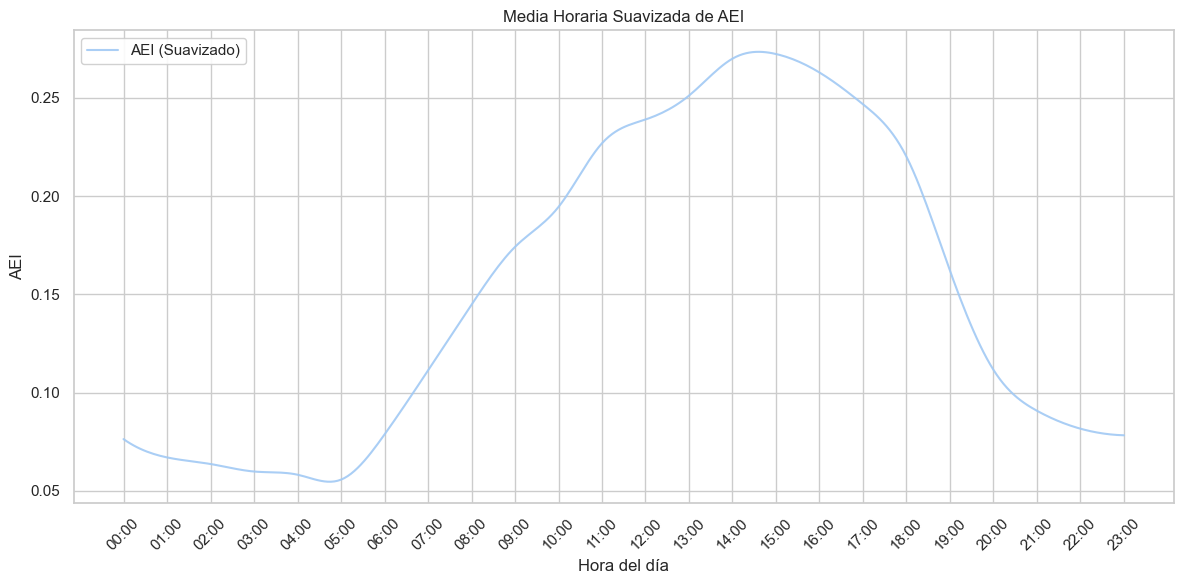

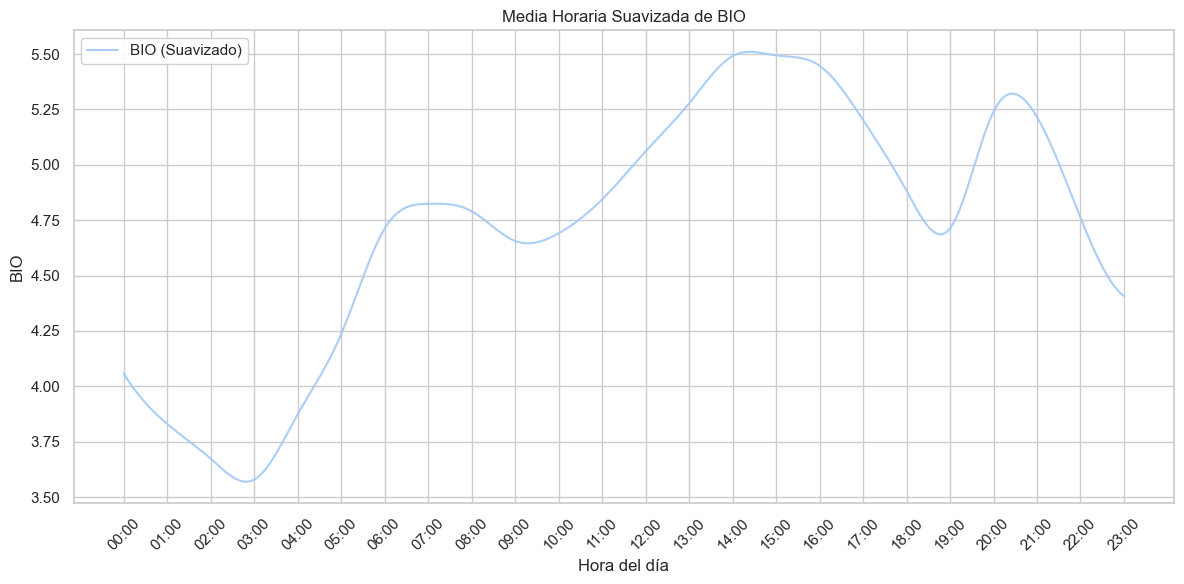

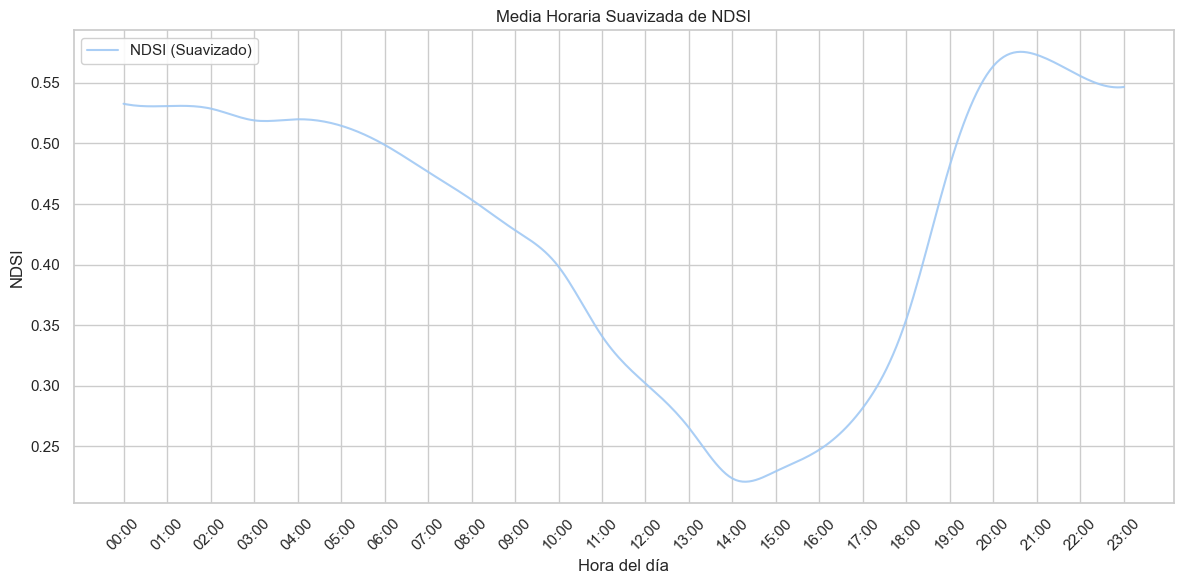

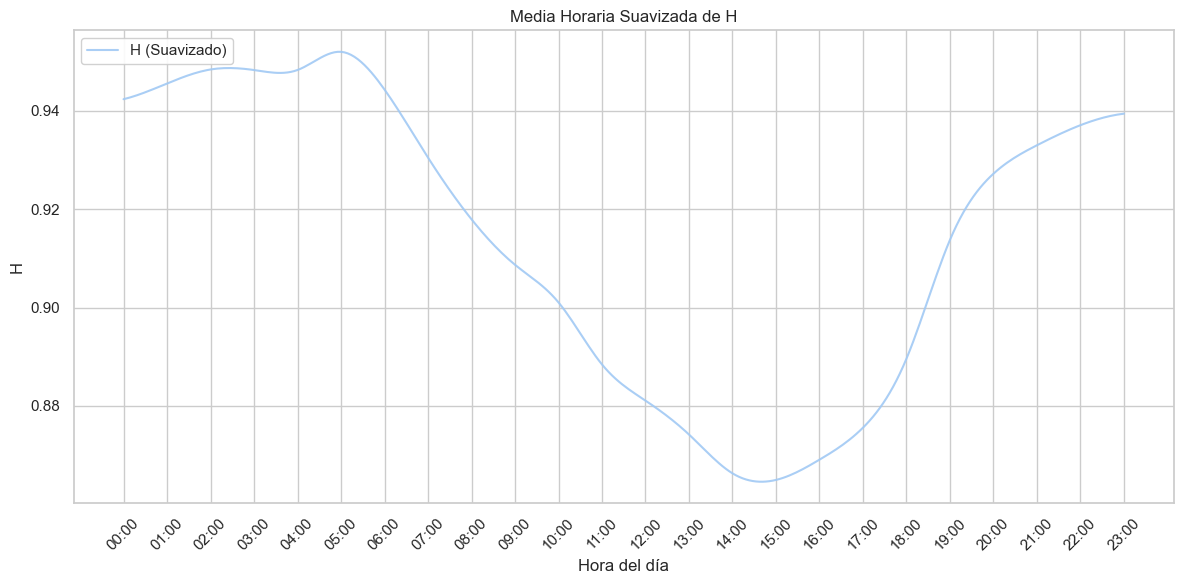

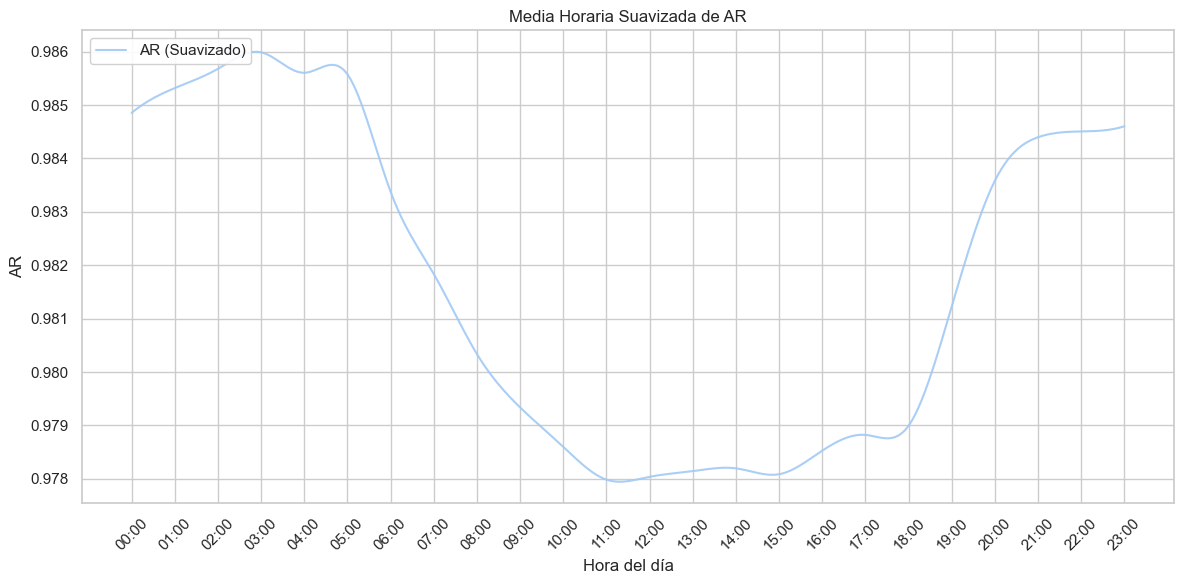

In [ ]:
from scipy.interpolate import make_interp_spline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Conexión y extracción de datos desde SQLite ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df_audio = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
conn.close()

# --- 2. Conversión de fechas y extracción de hora ---
df_audio["datetime"] = pd.to_datetime(df_audio["datetime"])
df_audio["hour"] = df_audio["datetime"].dt.hour

# --- 3. Agregación horaria ---
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]
df_audio = df_audio.dropna(subset=indices)
audio_hourly = df_audio.groupby("hour")[indices].mean().reset_index()
audio_hourly["hour_label"] = audio_hourly["hour"].apply(lambda x: f"{int(x):02d}:00")
audio_hourly = audio_hourly.sort_values("hour")

# --- 4. Visualización estilo suavizado pastel ---
sns.set_theme(style="whitegrid", palette="pastel")
pastel_palette = sns.color_palette("pastel")
index_color = pastel_palette[0]

for idx in indices:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Datos base
    x = audio_hourly["hour"]
    y = audio_hourly[idx]
    x_labels = audio_hourly["hour_label"]

    # Línea suavizada
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)

    # Plot suavizado
    ax.plot(x_smooth, y_smooth, color=index_color, alpha=0.9, label=f"{idx} (Suavizado)")

    # Eje y etiquetas
    ax.set_xlabel("Hora del día")
    ax.set_ylabel(f"{idx}")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_title(f"Media Horaria Suavizada de {idx}")
    ax.tick_params(axis='y')

    # Leyenda interna
    legend = ax.legend(loc='upper left', frameon=True)
    legend.set_zorder(10)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)

    plt.tight_layout()
    plt.show()

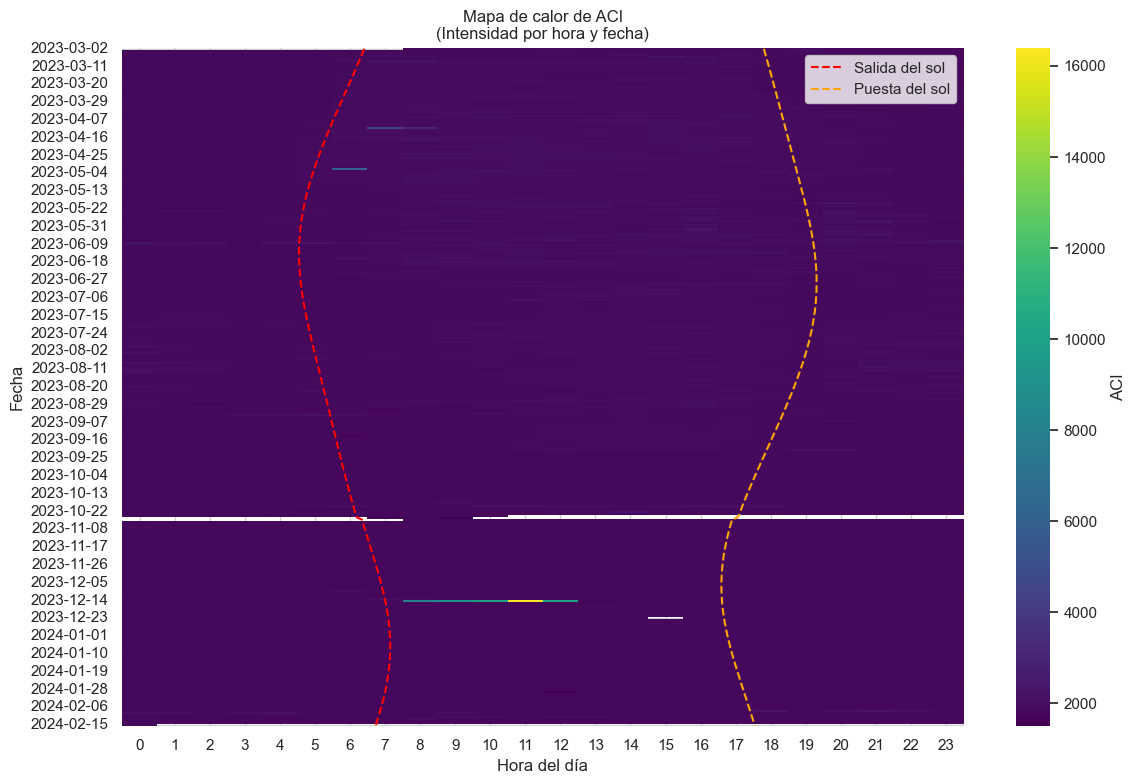

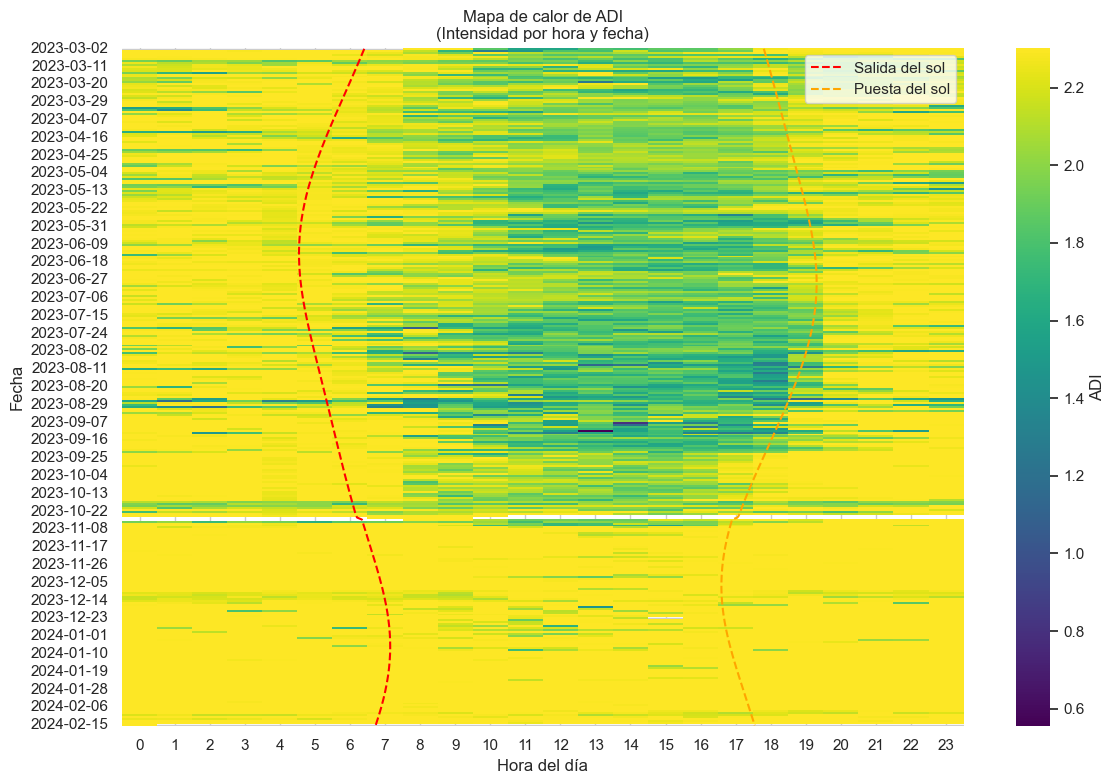

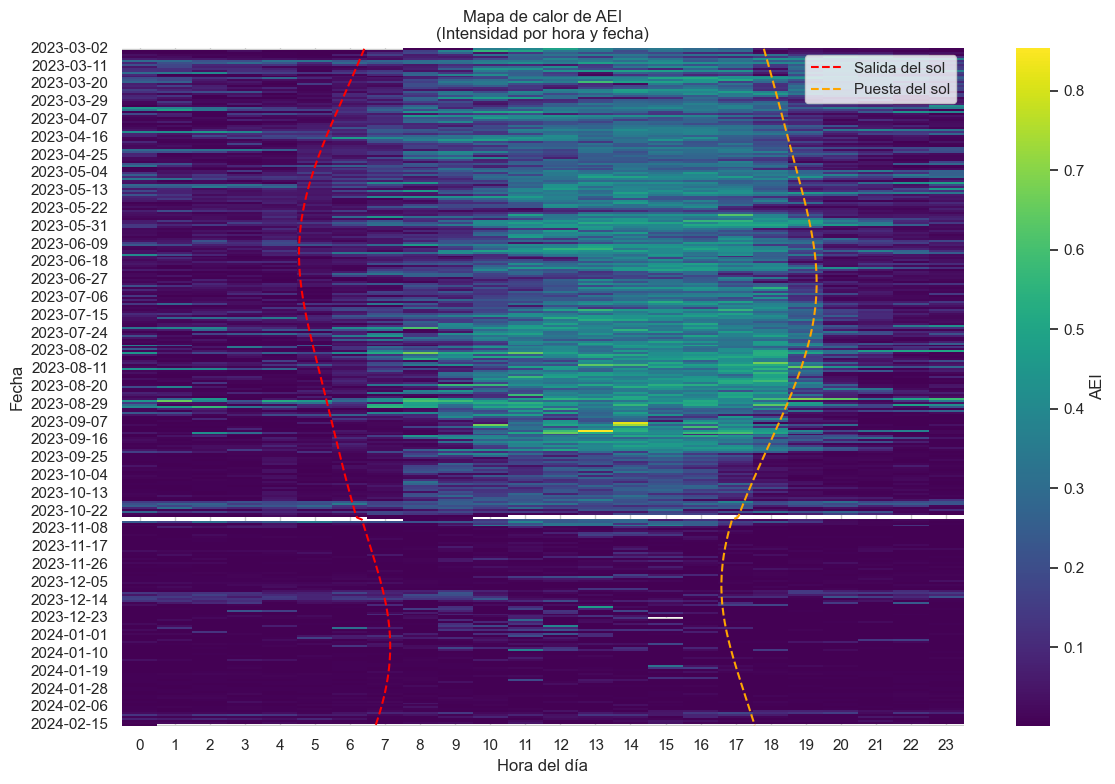

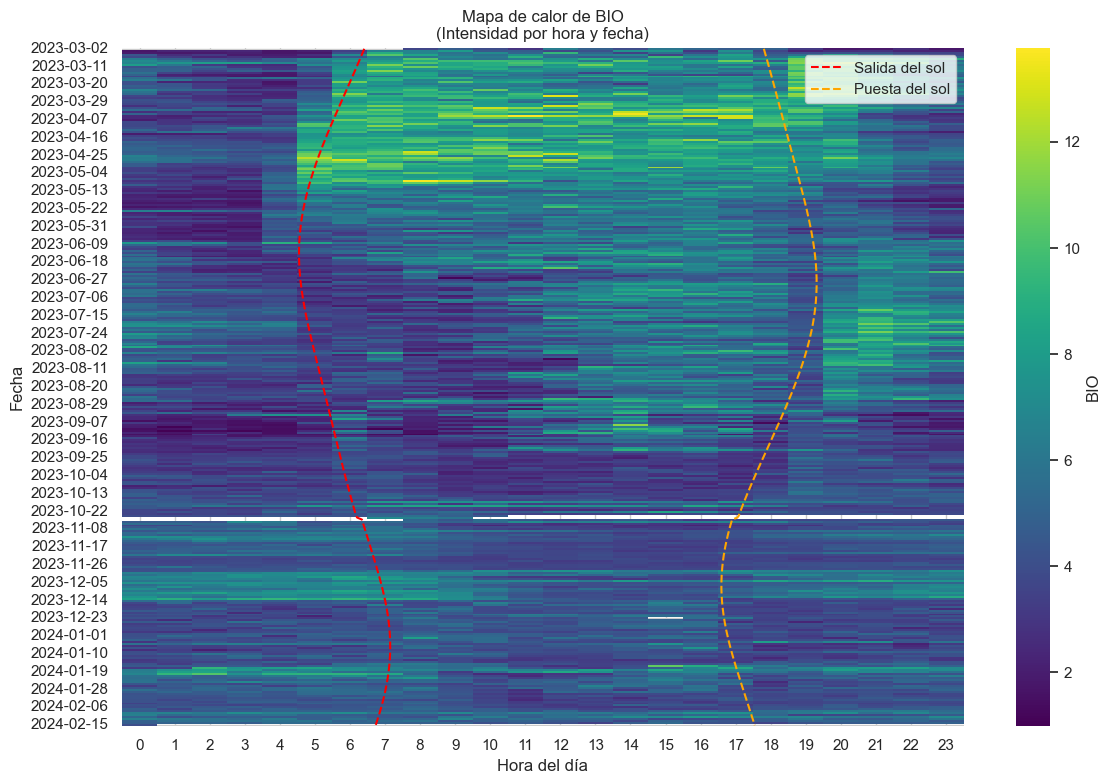

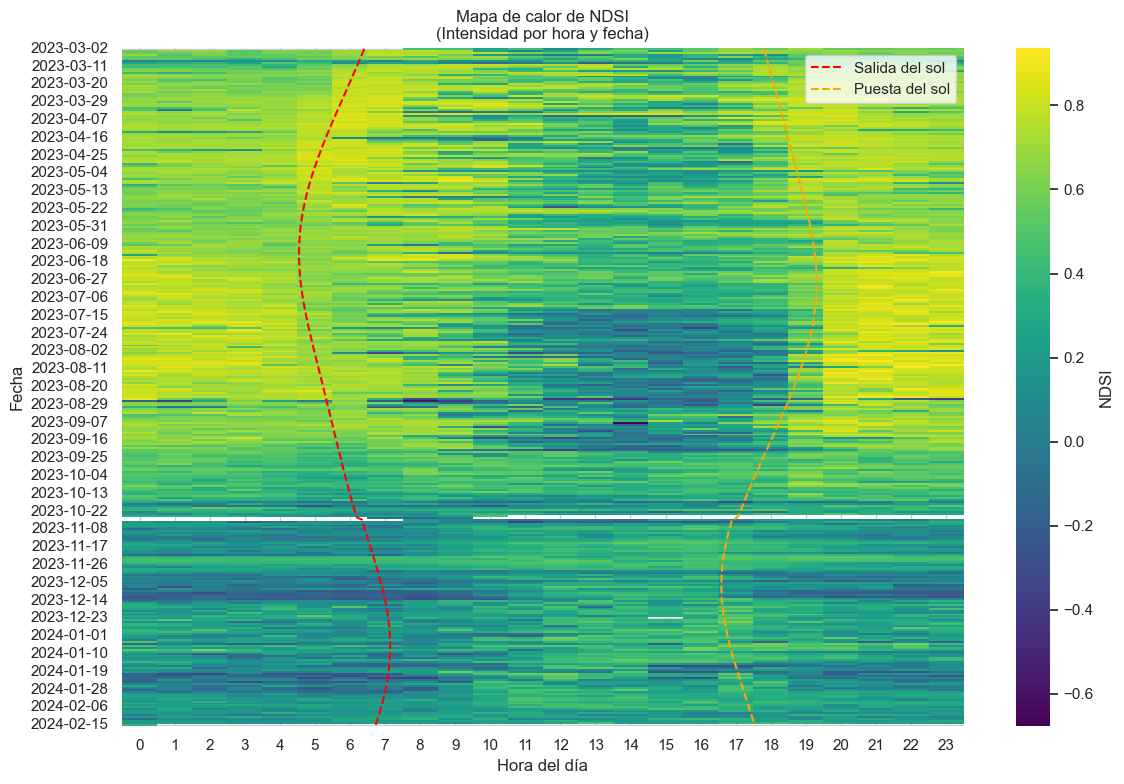

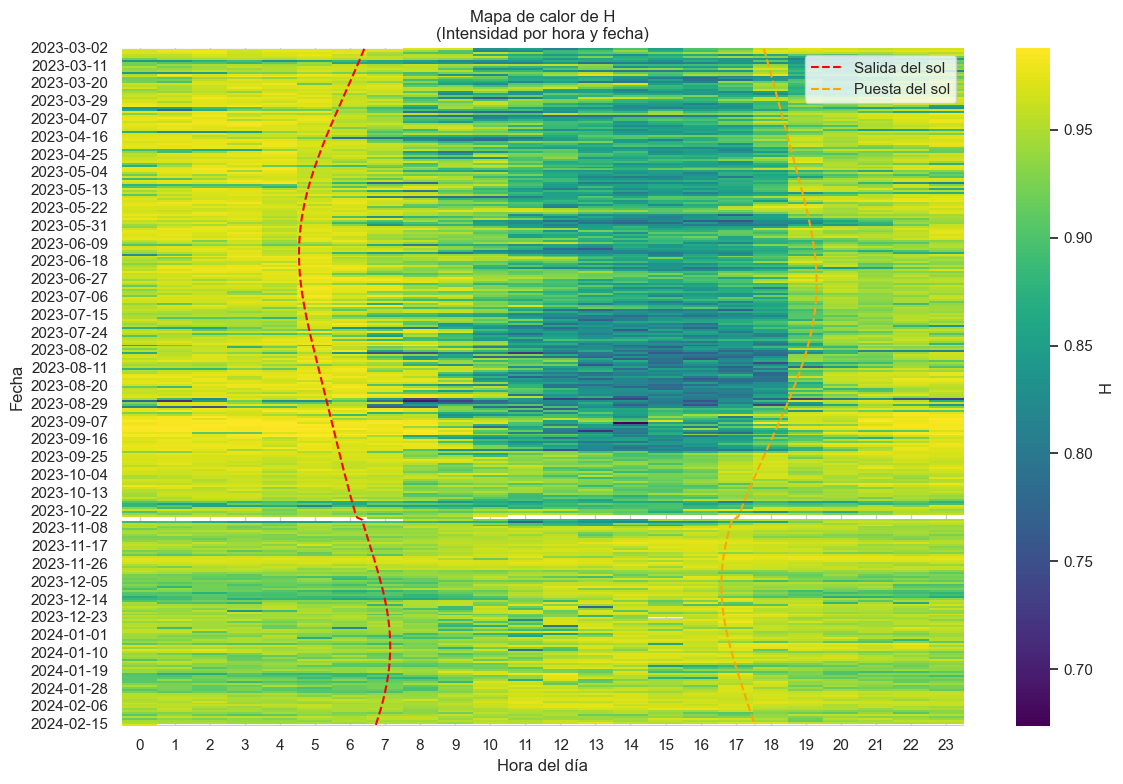

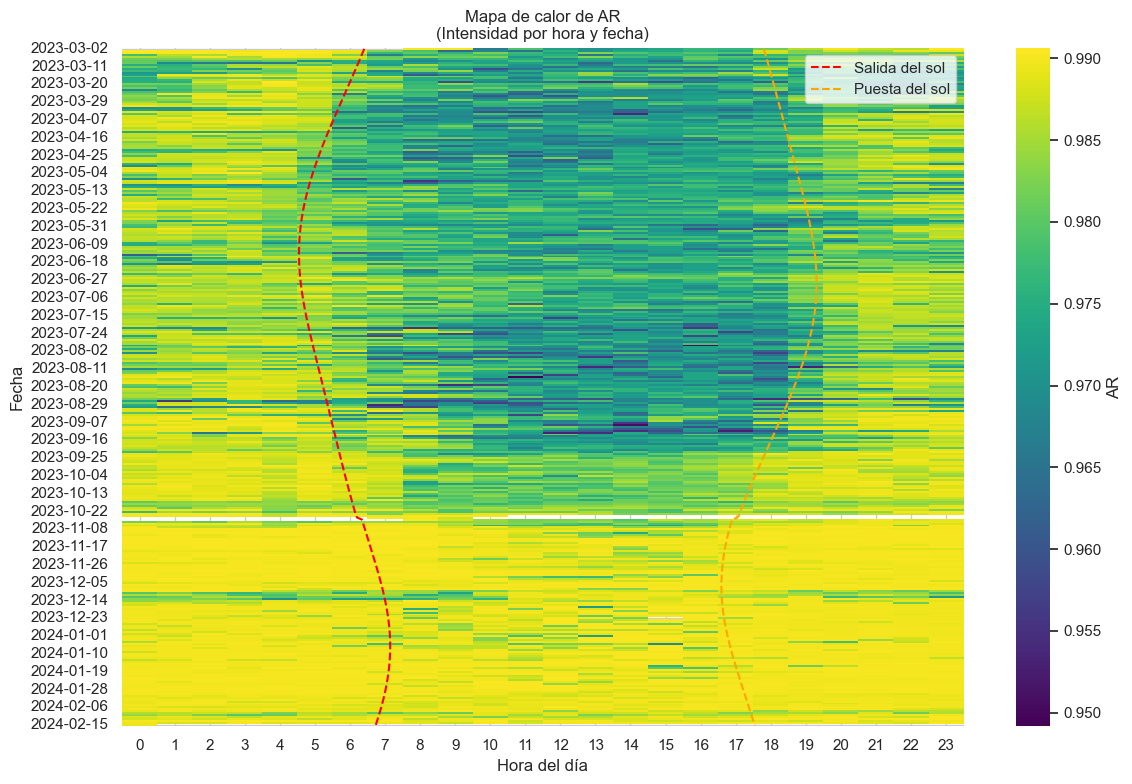

In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astral import LocationInfo
from astral.sun import sun
import datetime
import numpy as np

# --- 1. Conexión y extracción de datos desde SQLite ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df_audio = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
conn.close()

# --- 2. Conversión de fechas y filtrado del rango deseado ---
df_audio["datetime"] = pd.to_datetime(df_audio["datetime"])
mask = (df_audio["datetime"] >= "2023-03-01") & (df_audio["datetime"] <= "2024-02-15")
df_audio = df_audio.loc[mask]

# --- 3. Extraer la fecha (sin hora) y la hora ---
df_audio["date"] = df_audio["datetime"].dt.date  # Solo la fecha (sin hora)
df_audio["hour"] = df_audio["datetime"].dt.hour

# Lista de índices a analizar (puedes elegir uno en particular)
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# --- 4. Definir la ubicación de Sevilla para calcular los horarios ---
# Coordenadas aproximadas de Sevilla
sevilla = LocationInfo("Sevilla", "Spain", "Europe/Madrid", 37.3886, -5.9823)

# --- 5. Crear heatmap para cada índice e incluir las curvas de salida y puesta del sol ---
sns.set_theme(style="whitegrid", palette="pastel")
for idx in indices:
    # Eliminar filas con valores nulos en el índice actual
    df_idx = df_audio.dropna(subset=[idx])

    # Crear tabla pivote: filas = fecha, columnas = hora, valor = media del índice
    pivot = df_idx.pivot_table(values=idx, index="date", columns="hour", aggfunc="mean")
    pivot = pivot.sort_index()  # Ordenar cronológicamente las fechas

    # Preparar los vectores para las curvas de salida y puesta
    # Se utilizarán los índices de las filas del heatmap (se asume que el heatmap
    # muestra la primera fila en la parte superior, por lo que usaremos np.arange)
    dates = pivot.index
    n_dates = len(dates)
    # Cada fila del heatmap está centrada en su posición (0.5, 1.5, 2.5, ...)
    y_coords = np.arange(n_dates) + 0.5

    sunrise_hours = []
    sunset_hours = []
    for d in dates:
        # Asegurarse de trabajar con un objeto date
        if not isinstance(d, datetime.date):
            d_parsed = pd.to_datetime(d).date()
        else:
            d_parsed = d
        s = sun(sevilla.observer, date=d_parsed)
        # Convertir a hora decimal (incluyendo minutos y segundos)
        sunrise_time = s["sunrise"]
        sunset_time = s["sunset"]
        sunrise_dec = sunrise_time.hour + sunrise_time.minute/60.0 + sunrise_time.second/3600.0
        sunset_dec = sunset_time.hour + sunset_time.minute/60.0 + sunset_time.second/3600.0
        sunrise_hours.append(sunrise_dec)
        sunset_hours.append(sunset_dec)

    # Visualización del heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': idx})
    ax.set_title(f"Mapa de calor de {idx}\n(Intensidad por hora y fecha)")
    ax.set_xlabel("Hora del día")
    ax.set_ylabel("Fecha")

    # Superponer las curvas de salida y puesta del sol.
    # Nota: El eje X en el heatmap representa las horas (0-23) y el eje Y la posición
    # de la fecha en la tabla pivote (de 0 a n_dates). Por ello se usan los y_coords.
    ax.plot(sunrise_hours, y_coords, color='red', linestyle='--', label='Salida del sol')
    ax.plot(sunset_hours, y_coords, color='orange', linestyle='--', label='Puesta del sol')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

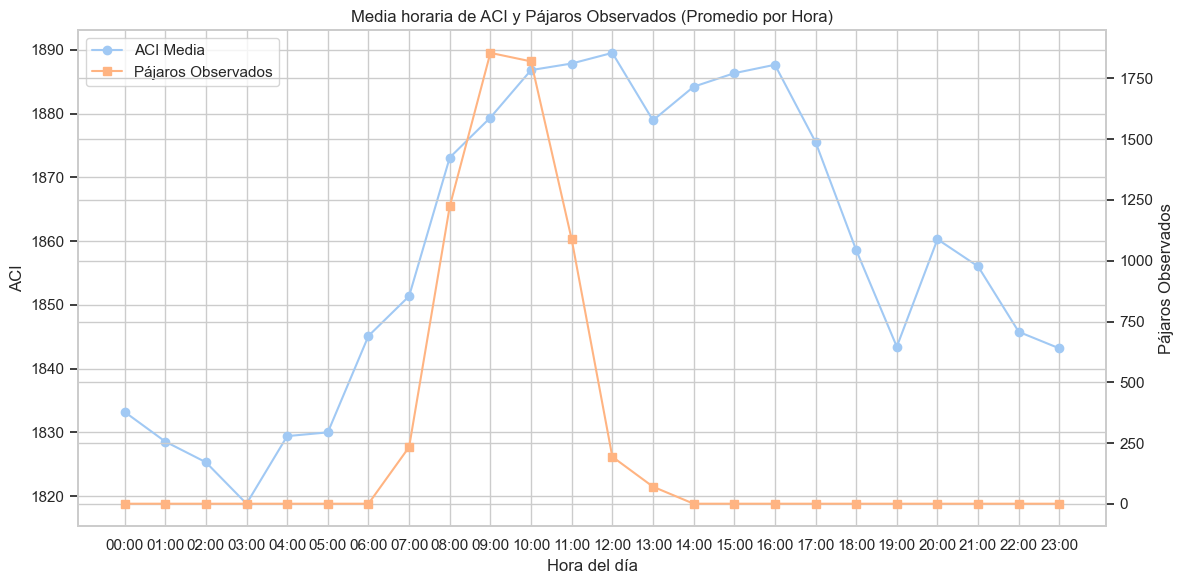

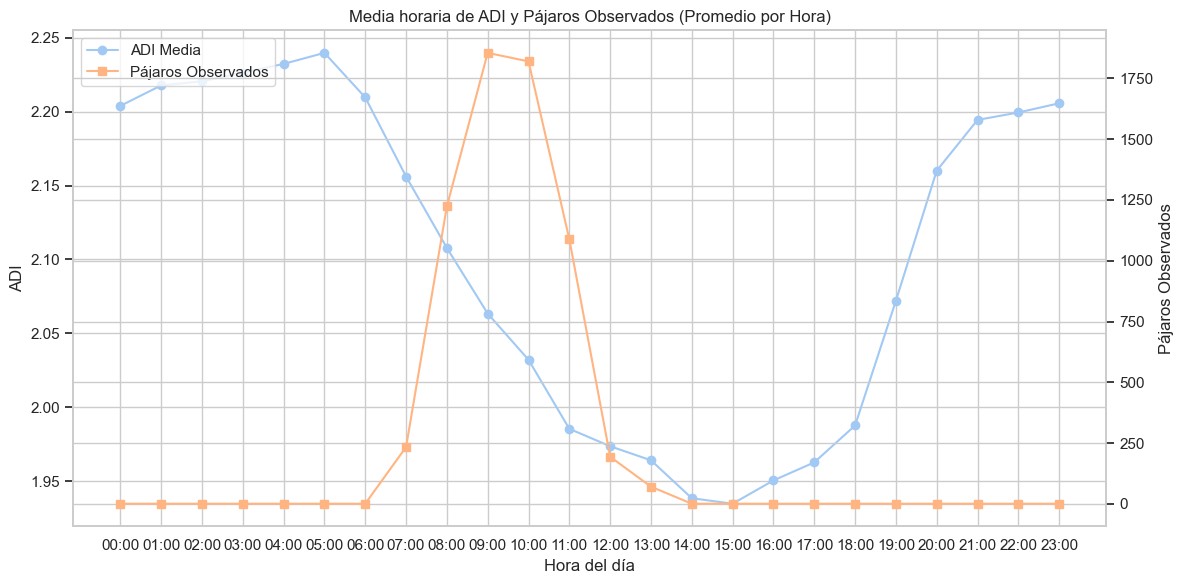

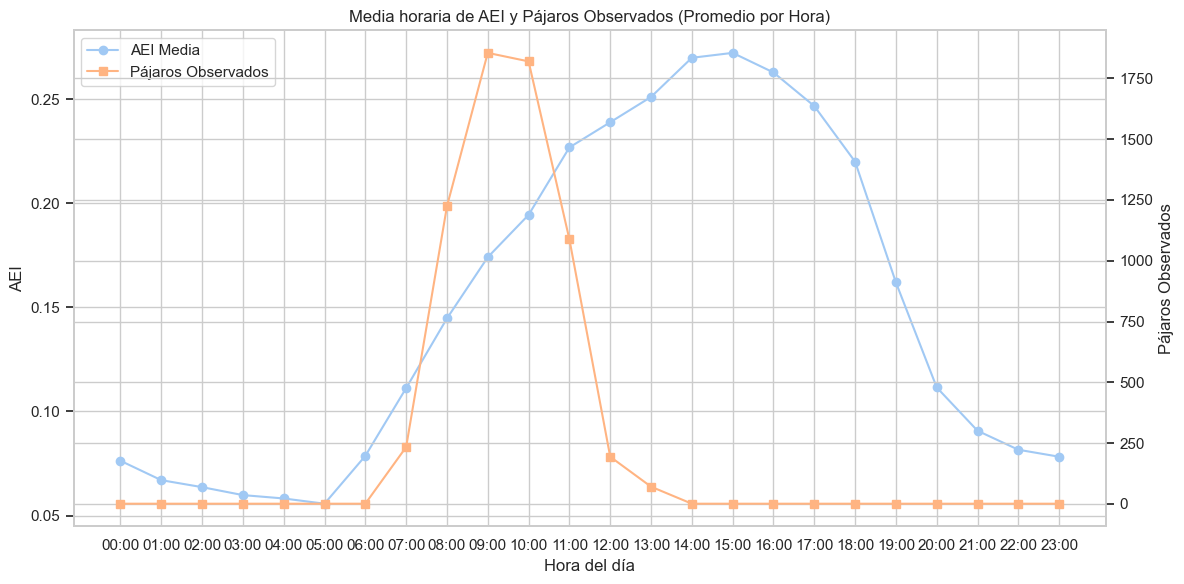

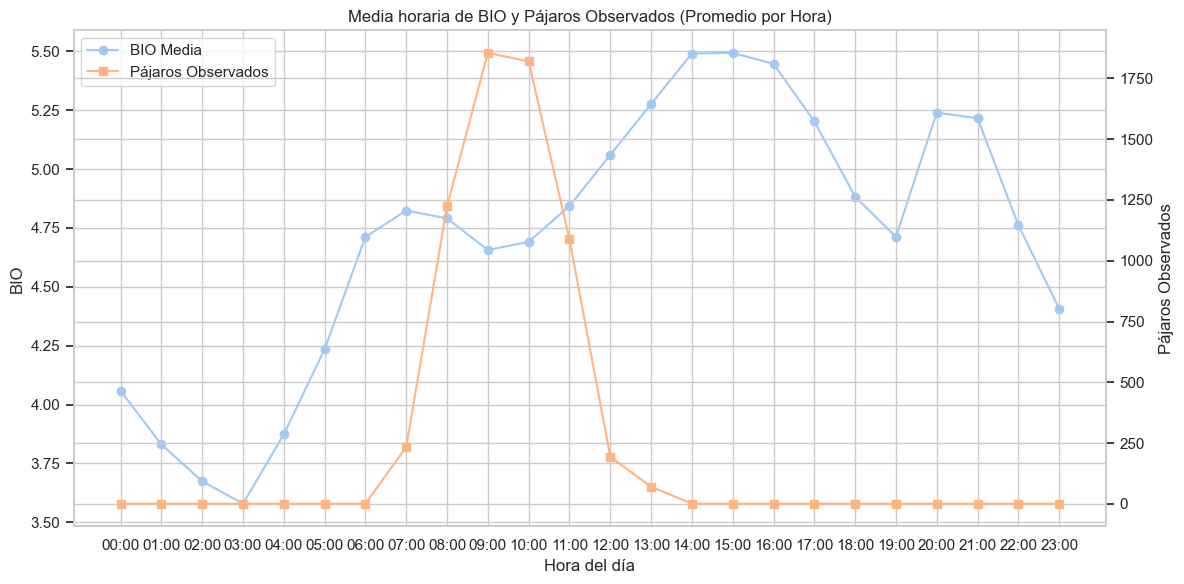

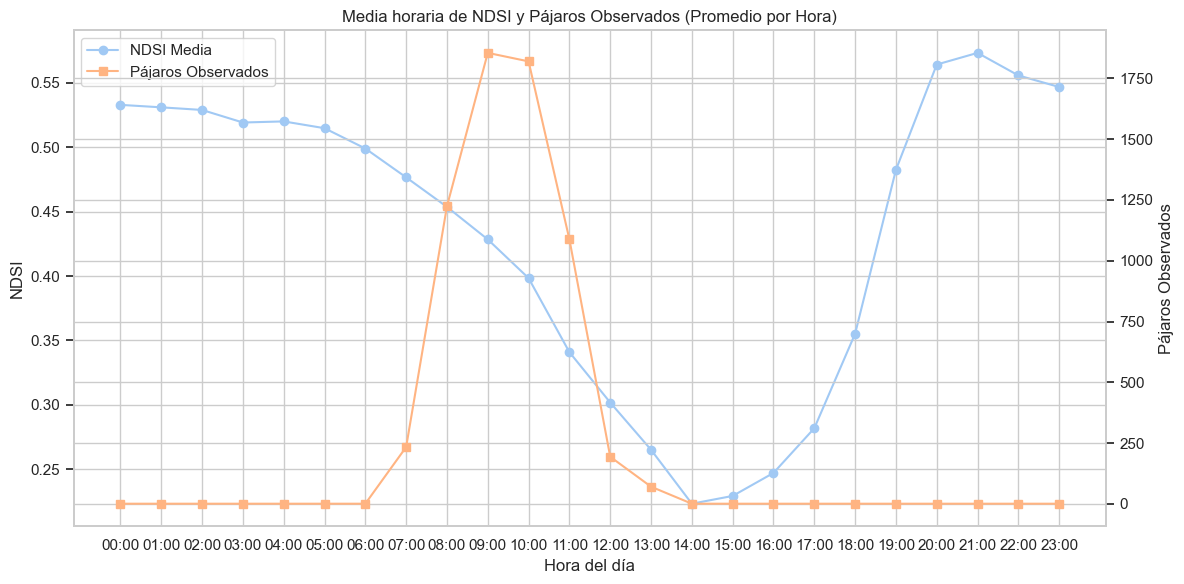

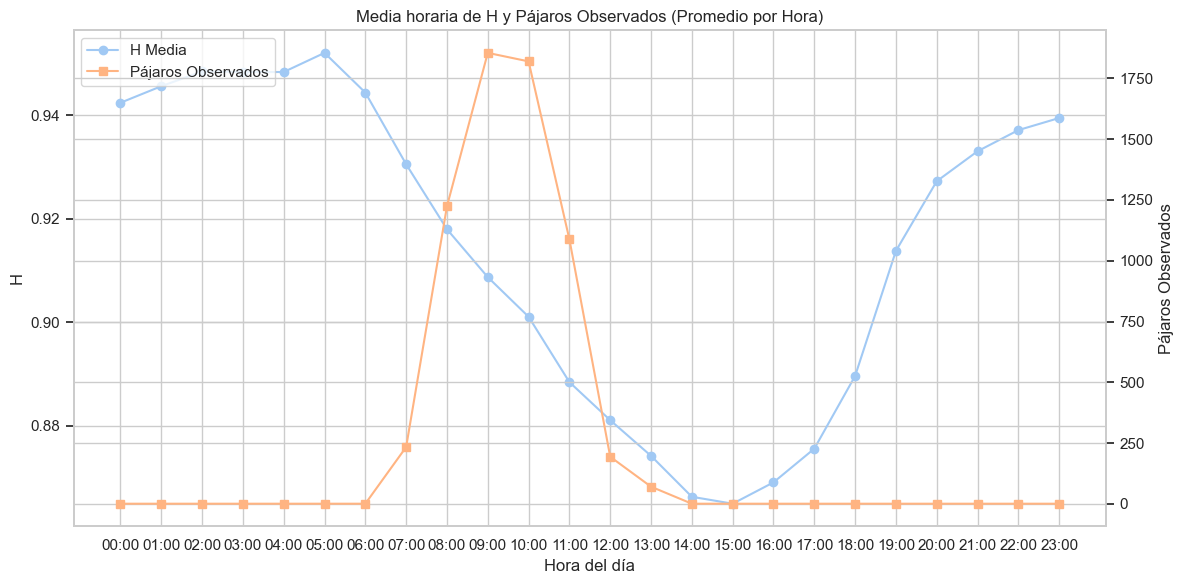

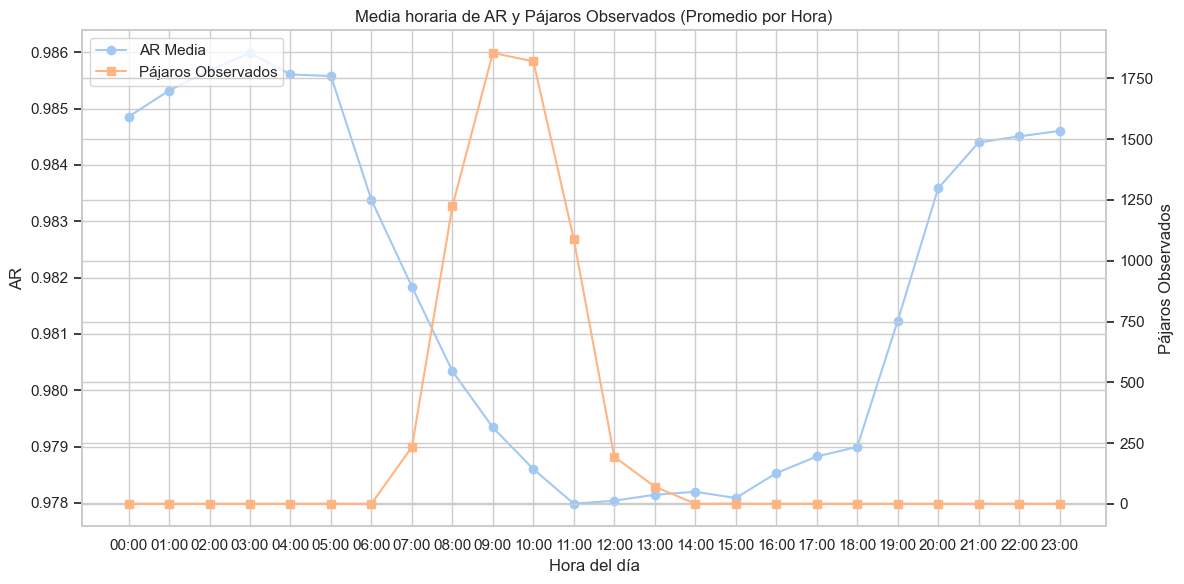

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Conexión y extracción de datos desde SQLite ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df_audio = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
df_obs = pd.read_sql_query("SELECT * FROM observations", conn)
conn.close()

# --- 2. Conversión de fechas y extracción de hora ---
# Para audio_metadata:
df_audio["datetime"] = pd.to_datetime(df_audio["datetime"])
df_audio["hour"] = df_audio["datetime"].dt.hour

# Para observations (se asume que la columna de fecha/tiempo se llama "datetime")
df_obs["datetime"] = pd.to_datetime(df_obs["datetime"], errors='coerce')
df_obs["hour"] = df_obs["datetime"].dt.hour

# --- 3. Agregación horaria ---
# Lista de índices a evaluar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Asegurarse de que en df_audio hay valores en los índices
df_audio = df_audio.dropna(subset=indices)

# Agrupar por hora y calcular la media para cada índice
audio_hourly = df_audio.groupby("hour")[indices].mean().reset_index()

# Para observations: contar el número de registros (suponiendo que cada fila es una observación)
obs_hourly = df_obs.dropna(subset=["datetime"]).groupby("hour").size().reset_index(name="bird_count")

# --- 4. Mapear número de hora a etiqueta (por ejemplo, "00:00", "01:00", etc.) y ordenar ---
audio_hourly["hour_label"] = audio_hourly["hour"].apply(lambda x: f"{int(x):02d}:00")
obs_hourly["hour_label"] = obs_hourly["hour"].apply(lambda x: f"{int(x):02d}:00")

audio_hourly = audio_hourly.sort_values("hour")
obs_hourly = obs_hourly.sort_values("hour")

# --- 5. Visualización con Seaborn y colores pastel ---
sns.set_theme(style="whitegrid", palette="pastel")
# Usamos dos colores pastel: uno para la media del índice y otro para el conteo de pájaros.
pastel_palette = sns.color_palette("pastel")
index_color = pastel_palette[0]
bird_color = pastel_palette[1]

for idx in indices:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Graficar la media horaria del índice
    ax1.plot(audio_hourly["hour_label"], audio_hourly[idx], marker='o', color=index_color, label=f"{idx} Media")
    ax1.set_xlabel("Hora del día")
    ax1.set_ylabel(f"{idx}")
    ax1.tick_params(axis='y')

    # Crear un segundo eje para el conteo de pájaros
    ax2 = ax1.twinx()
    ax2.plot(obs_hourly["hour_label"], obs_hourly["bird_count"], marker='s', color=bird_color, label="Pájaros Observados")
    ax2.set_ylabel("Pájaros Observados")
    ax2.tick_params(axis='y')

    plt.title(f"Media horaria de {idx} y Pájaros Observados (Promedio por Hora)")
    # Combinar leyendas de ambos ejes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()